
Training RandomForest...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best ROC AUC score for RandomForest: 0.7550

Training GradientBoosting...
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best ROC AUC score for GradientBoosting: 0.7607

Training LogisticRegression...
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best ROC AUC score for LogisticRegression: 0.7696

Selected best model: LogisticRegression

Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.68      0.79      1638
           1       0.31      0.73      0.43       314

    accuracy                           0.69      1952
   macro avg       0.62      0.70      0.61      1952
weighted avg       0.83      0.69      0.73      1952

Training ROC AUC: 0.7570
Training R²: -1.2961


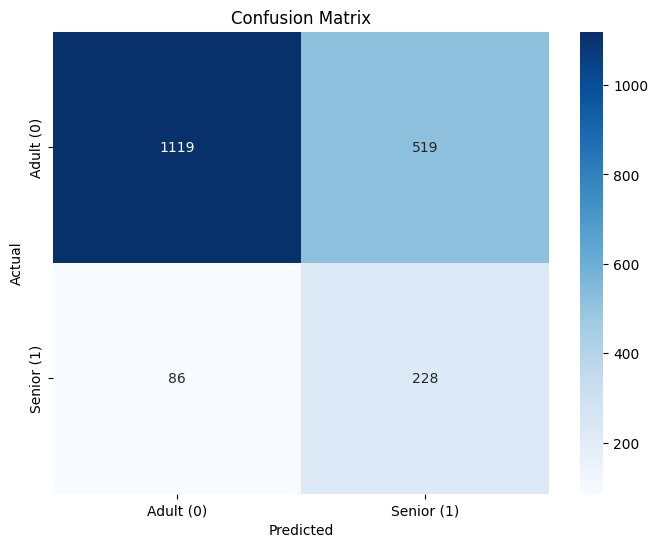


Submission saved as final_submission.csv with correct format (Adult=0, Senior=1)


In [64]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PowerTransformer
from sklearn.metrics import classification_report, confusion_matrix, r2_score, roc_auc_score
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load data
train_df = pd.read_csv("/content/Train_Data.csv")
test_df = pd.read_csv("/content/Test_Data.csv")

# Preprocessing
train_df.dropna(subset=['age_group'], inplace=True)
# Ensure correct mapping: Adult=0, Senior=1
train_df['age_group'] = train_df['age_group'].map({'Adult': 0, 'Senior': 1})

# Save test SEQN for submission
test_seqn = test_df['SEQN']

# Drop SEQN from both datasets
train_df.drop(columns=['SEQN'], inplace=True)
test_df.drop(columns=['SEQN'], inplace=True)

# Split features and target
X_train_raw = train_df.drop(columns=['age_group'])
y_train = train_df['age_group']

# Feature engineering - create meaningful interactions
if all(col in X_train_raw.columns for col in ['BMXBMI', 'LBXGLU']):
    X_train_raw['BMI_Glucose_ratio'] = X_train_raw['BMXBMI'] / (X_train_raw['LBXGLU'] + 1e-6)
    test_df['BMI_Glucose_ratio'] = test_df['BMXBMI'] / (test_df['LBXGLU'] + 1e-6)

if all(col in X_train_raw.columns for col in ['RIAGENDR', 'BMXBMI']):
    X_train_raw['Gender_BMI_interaction'] = X_train_raw['RIAGENDR'] * X_train_raw['BMXBMI']
    test_df['Gender_BMI_interaction'] = test_df['RIAGENDR'] * test_df['BMXBMI']

# Imputation with median
imputer = SimpleImputer(strategy='median')
X_train = pd.DataFrame(imputer.fit_transform(X_train_raw), columns=X_train_raw.columns)
X_test = pd.DataFrame(imputer.transform(test_df), columns=test_df.columns)

# Feature scaling with PowerTransformer
scaler = PowerTransformer()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection - use RFE for better selection
estimator = LogisticRegression(max_iter=1000, solver='liblinear')
selector = RFE(estimator, n_features_to_select=15, step=1)
X_train_selected = selector.fit_transform(X_train_scaled, y_train)
selected_features = X_train.columns[selector.support_]
X_test_selected = selector.transform(X_test_scaled)

# Split for validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train_selected, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Model selection with class weights to handle potential imbalance
models = {
    'RandomForest': RandomForestClassifier(class_weight='balanced', random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
}

param_grids = {
    'RandomForest': {
        'n_estimators': [100, 200],
        'max_depth': [5, 10, None],
        'min_samples_split': [2, 5]
    },
    'GradientBoosting': {
        'n_estimators': [100, 150],
        'learning_rate': [0.05, 0.1],
        'max_depth': [3, 5]
    },
    'LogisticRegression': {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
}

best_model = None
best_score = -1

for name, model in models.items():
    print(f"\nTraining {name}...")
    grid_search = GridSearchCV(model, param_grids[name], cv=StratifiedKFold(5),
                             scoring='roc_auc', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_split, y_train_split)

    val_score = grid_search.best_score_
    print(f"Best ROC AUC score for {name}: {val_score:.4f}")

    if val_score > best_score:
        best_score = val_score
        best_model = grid_search.best_estimator_

# Train best model on full training data
print(f"\nSelected best model: {type(best_model).__name__}")
best_model.fit(X_train_selected, y_train)

# Evaluation
train_preds = best_model.predict(X_train_selected)
train_probs = best_model.predict_proba(X_train_selected)[:, 1] if hasattr(best_model, "predict_proba") else [0]*len(train_preds)

print("\nClassification Report:\n", classification_report(y_train, train_preds))
print(f"Training ROC AUC: {roc_auc_score(y_train, train_probs):.4f}")
print(f"Training R²: {r2_score(y_train, train_preds):.4f}")

# Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_train, train_preds), annot=True, fmt='d', cmap='Blues',
            xticklabels=['Adult (0)', 'Senior (1)'], yticklabels=['Adult (0)', 'Senior (1)'])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Feature importance
if hasattr(best_model, 'feature_importances_'):
    plt.figure(figsize=(12, 6))
    importances = best_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.title("Feature Importance")
    plt.bar(range(len(selected_features)), importances[indices])
    plt.xticks(range(len(selected_features)), [selected_features[i] for i in indices], rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Generate predictions (ensuring 0=Adult, 1=Senior)
test_preds = best_model.predict(X_test_selected)

# Create submission
submission = pd.DataFrame({
    'SEQN': test_seqn,
    'age_group': test_preds.astype(int)  # Ensuring integers 0 or 1
})

# Verify we only have 0s and 1s
assert set(submission['age_group'].unique()).issubset({0, 1}), "Submission contains invalid values"
assert len(submission) == len(test_seqn), "Row count mismatch"

submission.to_csv("final_submission.csv", index=False)
print("\nSubmission saved as final_submission.csv with correct format (Adult=0, Senior=1)")